<h1>Оценка эффективности системы рекомендаций онлайн-магазина здорового питания</h1>
<p>У магазина есть приложение, внутри которого реализована рекомендательная система: она подсказывает пользователю, какие товары ему может быть интересно добавить в корзину. Раньше система была реализована довольно прямолинейно: пользователю предлагалось добавить те товары, которые он часто покупал в прошлом.</p>
<p>Однако был разработан новый алгоритм, который теперь работает на основе ИИ и предлагает в том числе и те товары, которые раньше пользователь не покупал</p>
<p>Вопрос: <b>действительно ли новый алгоритм работает лучше, чем существующий?</b></p>
<p>Чтобы ответить на него, был проведен A/B-тест, в ходе которого контрольная группа пользователей продолжала пользоваться старой версией системы рекомендаций, а экспериментальная группа использовала новый алгоритм. <b>Период проведения A/B-теста — с 01.10.2023 по 14.10.2023 включительно</b>.</p>

<h1>Данные</h1>
<p>Таблица <b>user</b> (Общая информация о пользователях магазина)</p>
<ul>
    <li>id (int) - идентификатор</li>
    <li>gender (str) - пол</li>
    <li>age (int) - возраст на момент 01.09.2023</li>
    <li>region (str) - регион, в котором проживает пользователь</li>
</ul>
<p></p>
<p></p>
<p>Таблица <b>user_ab_group</b> (Информация о том, в какую группу в рамках эксперимента входил тот или иной пользователь. В эксперименте участвовали не все пользователи)</p>
<ul>
    <li>user_id  (int) - идентификатор</li>
    <li>group  (str) - - группа, в которую входит пользователь (control/treatment)
</li>
</ul>

<p>Таблица <b>user_purchase</b> (Информация о покупках, которые совершали пользователи. Также в таблице содержаться данные о покупках тех же пользователей вне A/B-эксперимента)</p>
<ul>
    <li>id (int) - идентификатор покупки</li>
    <li>user_id  (int) - идентификатор пользователя, который совершил покупку</li>
    <li>date_time  (str) - момент времени, когда была совершена покупка. Формат: “%Y-%m-%d %H:%M:%S“</li>
</ul>

<p>Таблица <b>purchase_good</b> (Информация о товарах, которые входили в список покупок, совершенных пользователями. Каждому товару из конкретной покупки соответствует отдельная строчка в таблице)</p>
<ul>
    <li>purchase_id  (int) - идентификатор покупки</li>
    <li>good_id (int) - идентификатор товара, который входит в эту покупку</li>
    <li>amount (int) - кол-во единиц товара, входящих в покупку</li>
    <li>was_in_recommended_goods (bool) - был ли приобретенный продукт добавлен в корзину по рекомендации</li>
</ul>

<p>Таблица <b>good</b> (Информация о товарах, которые продаются в магазине)</p>
<ul>
    <li>id  (int) - идентификатор покупки</li>
    <li>good_name (string) - идентификатор товара, который входит в эту покупку</li>
    <li>price_per_unit (int) - кол-во единиц товара, входящих в покупку</li>
</ul>

In [1]:
# импорт библиотек
import random
import pandas as pd
import seaborn as sns

from scipy import stats
from math import floor

In [2]:
# чтение данных
user = pd.read_csv("data/user.csv")
user_ab_group = pd.read_csv("data/user_ab_group.csv")
good = pd.read_csv("data/good.csv")
user_purchase = pd.read_csv("data/user_purchase.csv")
purchase_good = pd.read_csv("data/purchase_good.csv")

In [3]:
user.head()

,user_id,gender,age,region
0,1,Ж,23,Краснодарский край
1,2,Ж,43,Краснодарский край
2,3,М,36,Краснодарский край
3,4,Ж,39,Краснодарский край
4,5,М,43,Иркутская область


In [4]:
user_ab_group.head()

,user_id,group
0,5034,treatment
1,4725,treatment
2,911,treatment
3,13267,control
4,5636,control


In [5]:
good.head()

,id,good_name,price_per_unit
0,1,Органический авокадо,336
1,2,Льняные семена,796
2,3,Кокосовое масло Extra Virgin,558
3,4,Гречка цельнозерновая,484
4,5,Лосось дикого копчения,480


In [6]:
user_purchase.head()

,id,user_id,date_time
0,1,5784,2023-09-20 00:01:07
1,2,4468,2023-09-20 00:04:18
2,3,3827,2023-09-20 00:04:35
3,4,3272,2023-09-20 00:06:32
4,5,9461,2023-09-20 00:08:24


In [7]:
purchase_good.head()

,purchase_id,good_id,amount,was_in_recommended_goods
0,15495,34,2,False
1,42640,48,1,False
2,42640,36,1,False
3,42640,12,2,True
4,42640,35,1,True


<h2>Обработка данных</h2>

<h4>Проверка типов данных</h4>

In [8]:
user.dtypes

user_id     int64
gender     object
age         int64
region     object
dtype: object

In [9]:
user_ab_group.dtypes

user_id     int64
group      object
dtype: object

In [10]:
good.dtypes

id                 int64
good_name         object
price_per_unit     int64
dtype: object

In [11]:
user_purchase.dtypes

id            int64
user_id       int64
date_time    object
dtype: object

In [12]:
user_purchase['date_time'] = pd.to_datetime(user_purchase['date_time'],
                                           format='%Y-%m-%d %H:%M:%S')

In [13]:
user_purchase.dtypes

id                    int64
user_id               int64
date_time    datetime64[ns]
dtype: object

<h4>Предварительный анализ</h4>

<h5>Таблица <b>user</b></h5>

In [14]:
user.head()

,user_id,gender,age,region
0,1,Ж,23,Краснодарский край
1,2,Ж,43,Краснодарский край
2,3,М,36,Краснодарский край
3,4,Ж,39,Краснодарский край
4,5,М,43,Иркутская область


In [15]:
user['gender'].value_counts()

gender
Ж    7636
М    7364
Name: count, dtype: int64

In [16]:
user['region'].value_counts()

region
Краснодарский край       4674
Санкт-Петербург          3474
Иркутская область        2222
Нижегородская область    2036
Оренбургская область     1559
Астраханская область      735
Республика Адыгея         300
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='Count'>

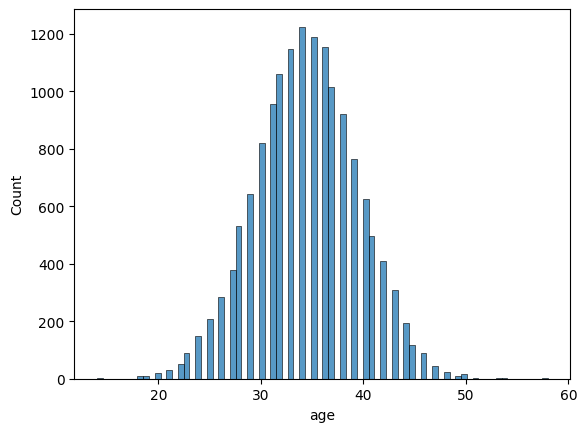

In [17]:
sns.histplot(user['age'])

In [18]:
user.describe()

,user_id,age
count,15000.000000,15000.000000
mean,7500.500000,34.429400
std,4330.271354,5.001122
min,1.000000,14.000000
25%,3750.750000,31.000000
50%,7500.500000,34.000000
75%,11250.250000,38.000000
max,15000.000000,58.000000


<p><b>Выводы</b></p>
<ul>
    <li>Среди пользователей примерно одинаковое кол-во мужчин и женщин</li>
    <li>Наибольшее число пользователей живут в Краснодарском крае</li>
    <li>Средний возраст пользователей - 34 года</li>
</ul>

<h5>Таблица <b>good</b></h5>

In [19]:
good.head()

,id,good_name,price_per_unit
0,1,Органический авокадо,336
1,2,Льняные семена,796
2,3,Кокосовое масло Extra Virgin,558
3,4,Гречка цельнозерновая,484
4,5,Лосось дикого копчения,480


In [20]:
good.describe()

,id,price_per_unit
count,100.000000,100.000000
mean,50.500000,508.860000
std,29.011492,99.104987
min,1.000000,299.000000
25%,25.750000,440.000000
50%,50.500000,496.000000
75%,75.250000,577.250000
max,100.000000,796.000000


In [21]:
good['good_name'].sort_values(ascending=True).unique()

array(['Авокадо-масло', 'Агавовый нектар', 'Алоэ вера напиток',
       'Амарантовые хлопья', 'Ананас сушёный',
       'Арахисовая паста без добавок', 'Белок гороха',
       'Белый чай в листьях', 'Бобовые чипсы', 'Бобы мунг',
       'Бразильские орехи', 'Брокколи свежий', 'Бурый рис',
       'Горчичное масло',
       'Горькая шоколадная плитка с высоким содержанием какао',
       'Горький миндальный шоколад', 'Гранатовый сок натуральный',
       'Гранулы соевого протеина', 'Грануляция колбасы из индейки',
       'Грецкие орехи', 'Греческий йогурт с низким содержанием жира',
       'Гречка цельнозерновая', 'Гуава сушёная', 'Зелёный горох свежий',
       'Зелёный чай высокого качества', 'Кардамон органический',
       'Кедровая мука', 'Кедровые орехи', 'Кедровые чипсы',
       'Кедровый мед', 'Кешью жареные', 'Киноа органическая',
       'Киноа-бургеры', 'Кишмиш-жмых', 'Кишмиш-масло', 'Кокосовая вода',
       'Кокосовое масло Extra Virgin', 'Кокосовые хлопья',
       'Кукурузные лепёшки 

In [22]:
good[(good['good_name'] == 'Авокадо-масло') | (good['good_name'] == 'Масло авокадо')]

,id,good_name,price_per_unit
76,77,Масло авокадо,548
90,91,Авокадо-масло,550


<p><b>Выводы</b></p>
<ul>
    <li>В списке товаров есть повторяющиеся позиции (Масло авокадо и Авокадо-масло)</li>
</ul>
<p><b>Гипотеза:</b> сначала товар назывался "масло авокадо", потом его переименовали</p>

In [53]:
a = purchase_good.merge(user_purchase, left_on='purchase_id', right_on='id')
b = a.merge(good, left_on='good_id', right_on='id')

In [24]:
b[(b['good_name'] == 'Авокадо-масло') | (b['good_name'] == 'Масло авокадо')] \
    .sort_values('date_time', ascending=True).tail()

,purchase_id,good_id,amount,was_in_recommended_goods,id_x,user_id,date_time,id_y,good_name,price_per_unit
61307,74923,91,1,False,74923,2589,2023-11-28 23:22:36,91,Авокадо-масло,550
155828,74926,91,1,False,74926,6622,2023-11-28 23:26:58,91,Авокадо-масло,550
155832,74926,77,1,False,74926,6622,2023-11-28 23:26:58,77,Масло авокадо,548
327150,74936,91,1,False,74936,13917,2023-11-28 23:38:41,91,Авокадо-масло,550
60586,74944,91,1,True,74944,2563,2023-11-28 23:49:39,91,Авокадо-масло,550


<p><b>Вывод:</b> гипотеза не подтвердилась, потому что оба товара покупались в том числе и в одинаковый день. Скорее всего, это сбой программы.</p>

<h5>Таблица <b>user_purchase</b></h5>

In [25]:
user_purchase.head()

,id,user_id,date_time
0,1,5784,2023-09-20 00:01:07
1,2,4468,2023-09-20 00:04:18
2,3,3827,2023-09-20 00:04:35
3,4,3272,2023-09-20 00:06:32
4,5,9461,2023-09-20 00:08:24


<Axes: xlabel='date_time', ylabel='Count'>

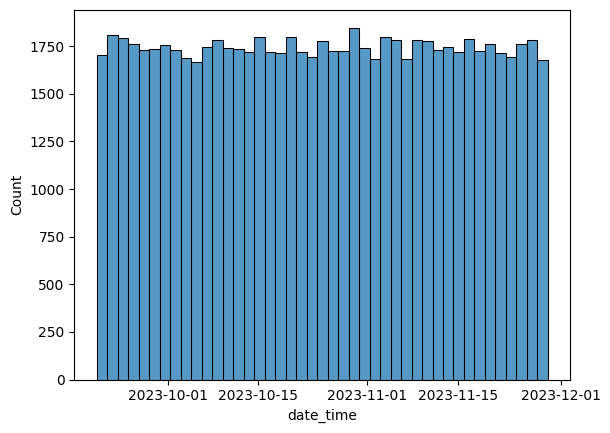

In [26]:
sns.histplot(user_purchase['date_time'])

<p><b>Выводы:</b> на графике видно, что нет аномальных скачков вверх или вниз, что говорит о независимости числа продаж от даты</p>

<h2>Анализ результатов A/B-теста</h2>

<h4>Проверка разбиения пользователей на группы</h4>

In [27]:
control_group = set(user_ab_group[user_ab_group['group'] == 'control']['user_id'])
treatment_group = set(user_ab_group[user_ab_group['group'] == 'treatment']['user_id'])

In [28]:
control_group & treatment_group

set()

In [29]:
user_ab_group.groupby('group', as_index=False) \
            .agg({'user_id': 'count'}) \
            .rename(columns={'user_id': 'cnt'})

,group,cnt
0,control,5925
1,treatment,5990


In [30]:
our_diff = len(treatment_group) - len(control_group)

In [31]:
our_diff

65

In [56]:
len(treatment_group) / len(control_group)

1.0121930567315833

<p>Сделаем проверку на наличие ошибки <b>Sample Ratio Mismatch (SRM)</b> - равновероятно ли пользователи распределяются в группы?</p>

<p>Насколько вероятно наблюдать такое же различие при разбиении на группы?</p>

In [32]:
diffs = []

for i in range(10_000):
    arr = [random.randint(0, 1) for _ in range(len(user_ab_group))]
    # 0 - экспериментальная
    # 1 - контрольная
    diff = sum(arr) - (len(arr) - sum(arr)) # различие кол-ва пользователей в группах
    diffs.append(diff)

In [33]:
diffs_s = pd.Series(diffs)

In [34]:
diffs_s

0         7
1       -75
2       107
3       -25
4       133
       ... 
9995     75
9996    111
9997   -107
9998    143
9999    219
Length: 10000, dtype: int64

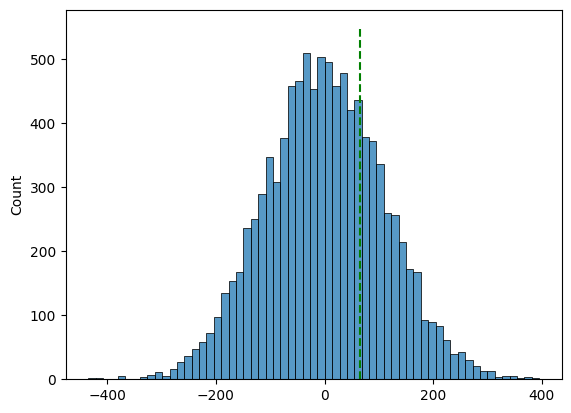

In [35]:
ax = sns.histplot(diffs_s)
ax.vlines([our_diff], 0, 550, linestyles='dashed', color='green')

In [36]:
alpha = 0.05
half_alpha = floor(len(diffs_s) * alpha / 2)
diffs_cut = sorted(diffs_s)[half_alpha:-half_alpha]

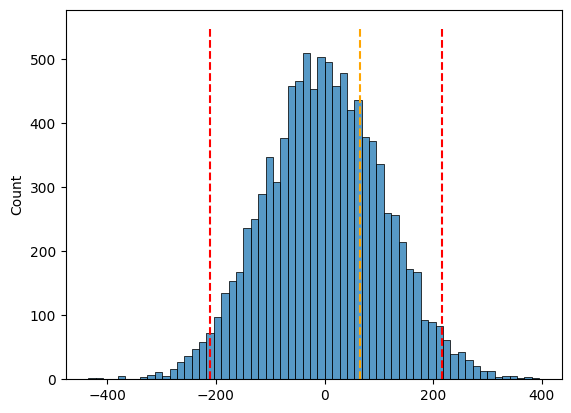

In [37]:
ax = sns.histplot(diffs_s)

ax.vlines([our_diff], 0, 550, linestyles='dashed', color='orange')
ax.vlines([diffs_cut[0], diffs_cut[-1]], 0, 550, linestyles='dashed', color='red')

<p>Значение не попало в критические области, следовательно, ошибка SRM отсутствует и разбиение на группы прошло должным образом</p>

<h4>Работа с данными</h4>

<p>Период проведения эксперимента — с 01.10.2023 по 14.10.2023 включительно.</p>

In [38]:
# user + user_ab_group
t1 = pd.merge(user, user_ab_group, left_on='user_id', right_on='user_id')

#t1 + user_purchase
t2 = pd.merge(t1, user_purchase, left_on='user_id', right_on='user_id') \
        .rename(columns={'id':'purchase_id'})

#t2 + purchase_good
t3 = pd.merge(t2, purchase_good, left_on='purchase_id', right_on='purchase_id') \
        .sort_values(['user_id', 'purchase_id', 'good_id'])

In [39]:
ab_result_table = t3[(t3['date_time'] >= '2023-10-01') &
                    (t3['date_time'] >= '2023-10-01')]

In [40]:
ab_result_table = ab_result_table \
                    .drop(columns=['gender', 'age', 'region', 'date_time', 'amount']) \
                    .sort_values(['user_id', 'purchase_id', 'good_id'],
                                ascending=True)

In [41]:
ab_result_table['was_in_recommended_goods'] = ab_result_table['was_in_recommended_goods'] \
                                                .astype('int')

In [42]:
ab_result_table.head()

,user_id,group,purchase_id,good_id,was_in_recommended_goods
0,1,control,15495,34,0
3,1,control,42640,12,1
4,1,control,42640,35,1
2,1,control,42640,36,0
1,1,control,42640,48,0


In [43]:
t1 = ab_result_table.groupby(['user_id', 'group', 'purchase_id'], as_index=False) \
               .agg({'was_in_recommended_goods': lambda x: round(x.mean(), 2)})

In [44]:
t2 = t1.groupby('user_id', as_index=False) \
       .agg({'was_in_recommended_goods': lambda x: round(x.mean(), 3)})

In [45]:
#t2 + user_ab_group
result_table = pd.merge(t2, user_ab_group, left_on='user_id', right_on='user_id')

In [46]:
result_table.head()

,user_id,was_in_recommended_goods,group
0,1,0.375,control
1,2,0.424,treatment
2,4,0.650,control
3,6,0.625,treatment
4,9,0.473,control


In [47]:
result_table = result_table.rename(columns={'was_in_recommended_goods': 'metric'})

<h2>Проверим выборки на нормальность распределения</h2>

<Axes: xlabel='metric', ylabel='Count'>

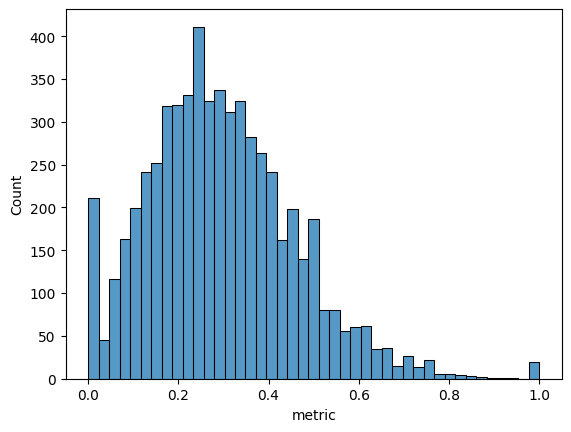

In [48]:
sns.histplot(result_table[result_table['group'] == 'control']['metric'])

<Axes: xlabel='metric', ylabel='Count'>

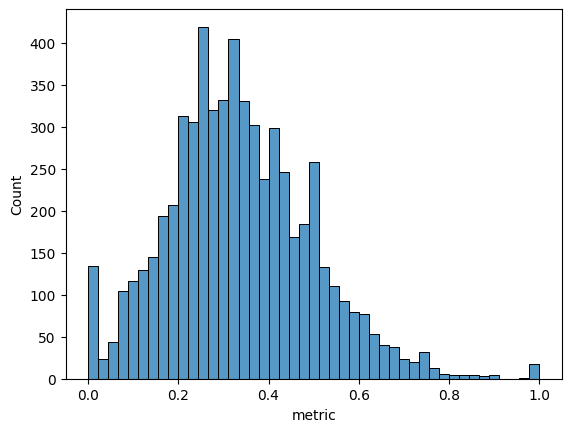

In [49]:
sns.histplot(result_table[result_table['group'] == 'treatment']['metric'])

<h3>Проверка гипотезы</h3>
<ul>
<li><p><b>H1</b>: Доля покупок с рекомендованными товарами <b>поменялась</b> в экспериментальной группе, чем в контрольной</p></li>
<li><p><b>H0</b>: Доля покупок с рекомендованными товарами <b>такая же</b> в экспериментальной группе по сравнению с контрольной</p></li>
</ul>

In [58]:
from scipy.stats import levene, ttest_ind

In [60]:
# проверка равенства дисперсий (тест Левена)
# в качестве 1го аргумента - значения метрик контрольной группы (control),
# в качестве 2го аргумента - значения метрик экспериментальной группы (treatment)

stats, pvalue = levene(result_table[result_table['group'] == 'control']['metric'],
      result_table[result_table['group'] == 'treatment']['metric'])

In [63]:
round(stats, 2)

np.float64(1.87)

In [64]:
round(pvalue, 2)

np.float64(0.17)

<p><b>pvalue > a (0.05)</b>, следовательно дисперсии в выборках равны</p>

In [66]:
stats, pvalue = ttest_ind(result_table[result_table['group'] == 'control']['metric'],
         result_table[result_table['group'] == 'treatment']['metric'],
         equal_var=True)

In [68]:
round(stats, 2)

np.float64(-13.28)

In [73]:
pvalue

np.float64(5.77755723798666e-40)

<h3>Результат</h3>
<p>значение pvalue сильно больше уровня значимости a=0.05, следовательно мы не можем отклонить нулевую гипотезу</p>
<p>Таким образом, <b>внедрение нового алгоритма рекомендаций не повлияло на выбор покупателей</b></p>